In [1]:
import pandas as pd
import numpy as np
import math
from QuantLib import *
import scipy as sp
import scipy.stats as si
import statsmodels.api as sm
import pandas_datareader
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.arima.model import ARIMA
from sklearn import datasets , linear_model
from tabulate import tabulate
from pandas_datareader import data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sympy as sy
from sympy.stats import Normal, cdf
import urllib.request
import zipfile

In [2]:
class Data:
    
    def __init__(self, startDate, endDate):
        #startDate = starting date for our data
        #endDate = ending date for out data
        self.startDate = startDate
        self.endDate = endDate
        #super().__init__(startDate, endDate)
        
    # function to import the .csv file and apply any dates of interest
    def ImportDataFrame(self):
        df = pd.read_csv('./data/CurveData.csv')
        df.index = pd.to_datetime(df['Date'])
        #df = df.loc[self.startDate : self.endDate]
        return df
    
    def Statistics(self, df):
        plt.figure(figsize = (8,6))
        plt.title('correlation matrix')
        sns.heatmap(df.corr(), cmap="Reds", annot=False,fmt='.4g')
        plt.show()
        plt.figure(figsize = (8,6))
        plt.title('covariance matrix')
        sns.heatmap(df.corr(), cmap="Blues", annot=False,fmt='.4g')
        plt.show()
        df.describe()
        return
        

In [3]:
start_date = '2010-01-01'
end_date = '2021-11-01'
data = Data(start_date, end_date)
MasterDF = data.ImportDataFrame()
#for col in MasterDF.columns:
#    print(col)
#print(MasterDF.head())
DiscountCurve = MasterDF[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3","USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30",'USSAWP40','USSAWP50']]
DiscountCurve = DiscountCurve.dropna()
SwapCurve =  MasterDF[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3","USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30",'USSAWP40','USSAWP50']]
SwapCurve = SwapCurve.dropna()
SwapCurveCopy = SwapCurve.copy()

In [4]:
class FuturesTransform:
    
    def __init__(self, T_1, T_2, df):
        # T_1 = the time t_1 that the forward rate agreement would start at
        # T_2 = the time t_2 that the Forward rate would be, in our case either 3- or 1-month as a fraction of a year
        # df is the data frame of futures
        self.T_1 = T_1
        self.T_2 = T_2
        self.df = df
        
    def convertToRate(self):
        self.df = self.df[["EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"]]
        # rate = (100 - EDF price) / 100
        for col in self.df.columns:
            for index, row in self.df.iterrows():
                row[col] = (100 - row[col])/100
                
        return self.df     
        
    def HullWhiteConvexityAdjustment(self, df):
        #vol = self.df.var()* np.sqrt(2) /100
        for col in df.columns:
            vol = df[col].var() 
            std = df[col].std()
            #self.T_1 += 0.25
            self.T_2 = self.T_1 + 0.25
            print(std**2, 'squared stdev ')
            print(vol, " for df column =", col, " Fut")
            print('convexity adjustment   :',-(0.5 * 0.0081 * self.T_1 * self.T_2))
            for index, row in self.df.iterrows():
                row[col] = (row[col] - ((0.5 * vol * self.T_1 * self.T_2)))
            print(self.T_1)
            print(self.T_2)
            self.T_1 += 0.25
            #self.T_2 = self.T_1 + 0.25
        return df

In [5]:
futures = FuturesTransform(15/360, 0.0, DiscountCurve)
futuresRates = futures.convertToRate()
#futuresRates['ED1'].plot()
print(futuresRates.head(2))
forwardRates = futures.HullWhiteConvexityAdjustment(futuresRates)
print('*****************************************************')
print(forwardRates.head(2))
DiscountCurveCopy = DiscountCurve.drop(["EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3"], axis=1)
DiscountCurveCopy = DiscountCurveCopy/100
DiscountCurveAdjusted = pd.concat([DiscountCurveCopy, forwardRates], axis=1)
#DiscountCurveCopy = DiscountCurveCopy*100
print('*****************************************************')
print(DiscountCurveAdjusted.head(2))

                EDZ1     EDH2     EDM2     EDU2     EDZ2     EDH3
Date                                                             
2021-11-19  0.002150  0.00265  0.00460  0.00690  0.00950  0.01150
2021-11-18  0.002075  0.00245  0.00415  0.00645  0.00905  0.01105
0.00010698093442986902 squared stdev 
0.00010698093442986901  for df column = EDZ1  Fut
convexity adjustment   : -4.921875e-05
0.041666666666666664
0.2916666666666667
0.00011817306914809687 squared stdev 
0.00011817306914809686  for df column = EDH2  Fut
convexity adjustment   : -0.0006398437500000001
0.2916666666666667
0.5416666666666667
0.00011081421942615163 squared stdev 
0.00011081421942615163  for df column = EDM2  Fut
convexity adjustment   : -0.0017367187500000004
0.5416666666666667
0.7916666666666667
0.00012231703910091962 squared stdev 
0.00012231703910091962  for df column = EDU2  Fut
convexity adjustment   : -0.003339843750000001
0.7916666666666667
1.0416666666666667
0.0001378657345719407 squared stdev 
0.000137865

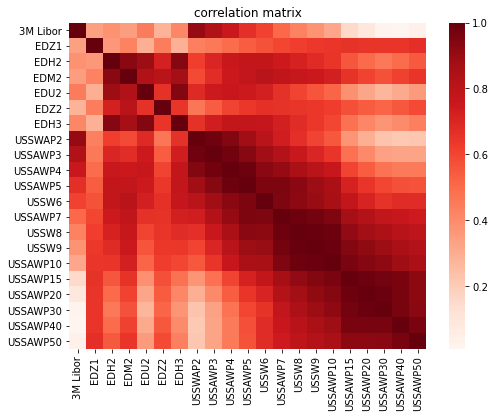

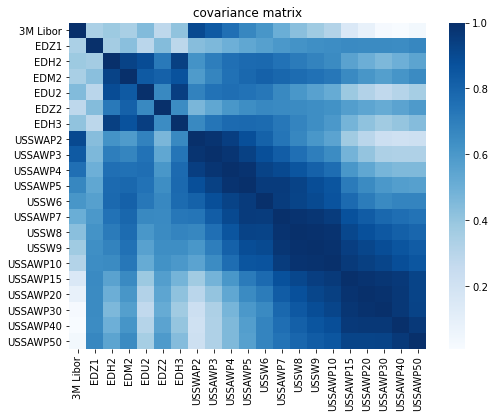

<AxesSubplot:xlabel='Date'>

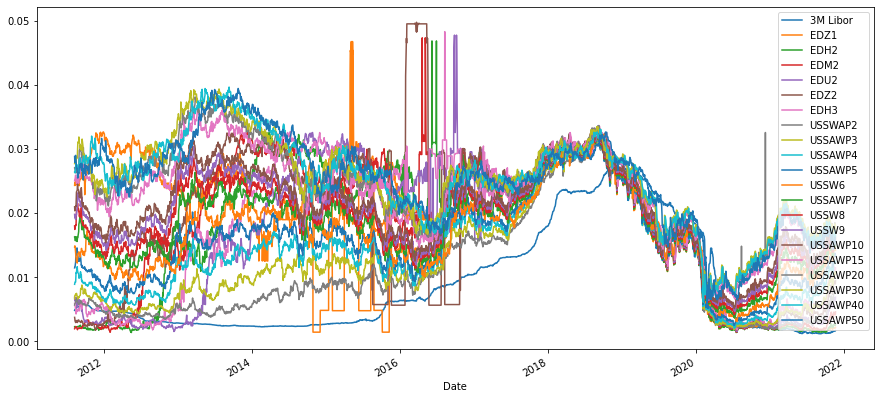

In [6]:
DiscountCurveAdjusted = DiscountCurveAdjusted[["3M Libor","EDZ1","EDH2","EDM2","EDU2","EDZ2","EDH3","USSWAP2","USSAWP3","USSAWP4","USSAWP5","USSW6","USSAWP7","USSW8","USSW9","USSAWP10","USSAWP15","USSAWP20","USSAWP30",'USSAWP40','USSAWP50']]
CurveMatrix = data.Statistics(DiscountCurveAdjusted)
#DiscountCurveC = DiscountCurve.loc['2012-01-01':'2021-11-01']
DiscountCurveAdjusted.plot(figsize = (15,7))


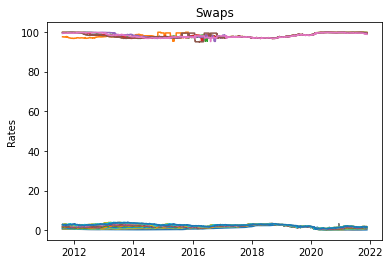

In [210]:
plt.plot(SwapCurve)
plt.ylabel("Rates")
plt.title("Swaps")
plt.show()
#print(SwapCurve.tail())

In [197]:
class StochasticProcess:
    
    def __init__(self, S0, kappa, theta, t, r, sigma, n):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        #kappa = speed of mean reversion
        #theta = the mean or 
        self.S0 = S0
        self.kappa = kappa
        self.theta = theta
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        
    def generate_simulated_stock_returns(self):
        # simulates the stock return values of a stock
        # goes directly to: generate_simulated_stock_values(self):
        mu = self.r
        returns = []
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            z = np.random.normal()
            stock_return = z * self.sigma * ((1 / self.n) ** 0.5)
            returns.append(stock_return)
        return np.array(returns)
    
    def generate_simulated_stock_values(self):
        # generates stock paths that can be used to value path dependant options
        stock_path = [self.S0]
        returns = self.generate_simulated_stock_returns()
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            #snext = stock_path[i] * np.exp(returns[i])
            #snext = stock_path[i] + returns[i]
            #snext = stock_path[i] + (self.kappa * (self.theta - stock_path[i]) * ((1 / self.n) ** 0.5)) + returns[i]
            snext = stock_path[i] + (self.kappa * (self.theta - stock_path[i] * np.exp(returns[i])) * ((1 / self.n) ** 0.5)) + returns[i]
            stock_path.append(snext)
        return np.array(stock_path)
    
    def Vasicek(self):
        # generates stock paths that can be used to value path dependant options
        stock_path = [self.S0]
        returns = self.generate_simulated_stock_returns()
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            #snext = stock_path[i] * np.exp(returns[i])
            #snext = stock_path[i] + returns[i]
            snext = (self.kappa * (self.theta - stock_path[i]) * ((1 / self.n) ** 0.5)) + returns[i]
            stock_path.append(snext)
        return np.array(stock_path)
    
    def plot_simulated_stock_values(self, num_trials = 1):
        # plots the simulation as a check to see if the paths look reasonable
        number_x = int(self.t * self.n//1)
        term_x = 1 / self.n
        x = 0
        list_for_x = [0]
        for i in range(number_x):
            x += term_x 
            list_for_x.append(x)
        for j in range(num_trials):
            list_y = self.generate_simulated_stock_values()
            plt.plot(list_for_x, list_y) 
        plt.title(f'{num_trials} simulated trials')
        plt.xlabel('years')
        plt.ylabel('$ value')
        return plt.show()

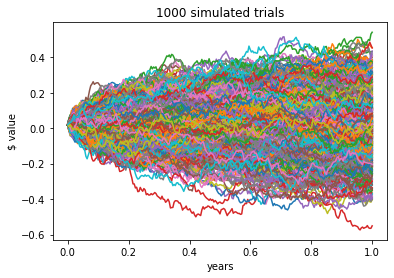

In [198]:
sim = StochasticProcess(0.02, 0.03, .0016, 1, 0.0016, 0.2, 252)
sim.plot_simulated_stock_values(1000)

In [199]:
class PCAAnalysis:
    
    def __init__(self,df,reconstruct):
            
        # df = dataFrame
        # reconstruct = the rates that have to reconstructed (12) input or 21
        self.df = df
        self.reconstruct = reconstruct
            
    def PCA(self):
        self.df -= self.df.mean(axis=0)
        Matrix = np.cov(self.df, rowvar=False)
        eigenvalues, eigenvectors = sp.linalg.eigh(Matrix)
        #print('eig vals: ',eigenvalues)
        eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
        eigenvalues = eigenvalues[np.argsort(eigenvalues)[::-1]]
        eigenvectors = eigenvectors[:, :self.reconstruct]
        
        return np.dot(eigenvectors.T, self.df.T).T, eigenvalues, eigenvectors 

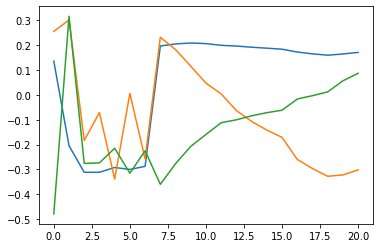

In [200]:
#swapmatrix = data.Statistics(SwapCurve)
scores, eigenvals, eigenvecs = PCAAnalysis(SwapCurveCopy,21).PCA()   
#scores, eigenvals, eigenvecs = PCAAnalysis(DiscountCurveAdjusted,21).PCA()
eigenvecs = pd.DataFrame(eigenvecs)
#print(eigenvecs.head())
plt.plot(eigenvecs.iloc[:, 0:3])
plt.show()

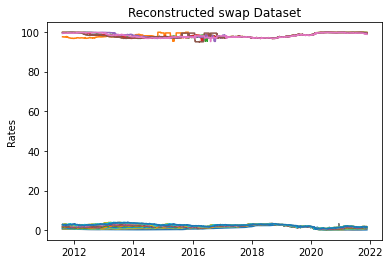

In [201]:
#print(SwapCurve.tail())
rebuilt = pd.DataFrame(np.dot(scores,eigenvecs.T), index=SwapCurve.index, columns=SwapCurve.columns)
for cols in rebuilt.columns:
    rebuilt[cols] = rebuilt[cols] + SwapCurve.mean(axis=0)[cols]
    #print(rebuilt[cols])
    #print(SwapCurve.mean(axis=0)[cols])
plt.plot(rebuilt)
plt.ylabel("Rates")
plt.title("Reconstructed swap Dataset")
plt.show()


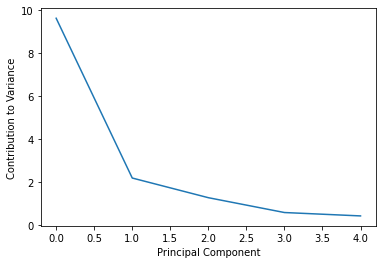

[9.63511737 2.17899673 1.26165697]


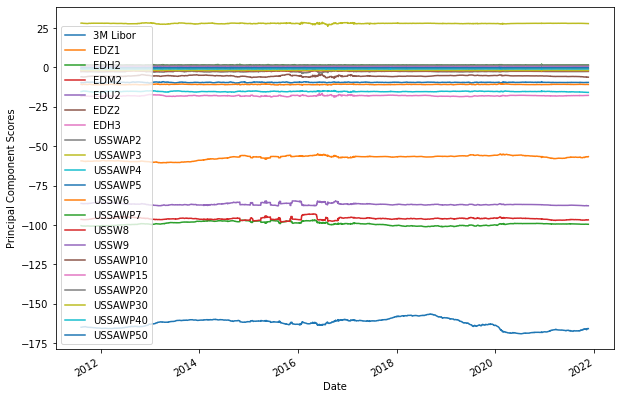

In [202]:
plt.plot(eigenvals[0:5])
plt.ylabel("Contribution to Variance")
plt.xlabel("Principal Component")
plt.show()
print(eigenvals[0:3])
scores = pd.DataFrame(np.dot(eigenvecs.T, SwapCurve.T).T, index=SwapCurve.index, columns=SwapCurve.columns)
scores.plot(figsize = (10,7))
plt.ylabel("Principal Component Scores")
plt.show()

In [211]:
class CurveConstruction:
    
    def __init__(self, lstTenors, curveDF, curveSlice, curveType):
        # lstTenors = the tenors of the curve that we want to build
        # curveDF = the dataFrame that we contains the specific curve data
        # curveSlice = the time period of the curve that we want to display, (0 = most recent day)
        # curveType = the BBG ID curve that we want to display e.g. the S23 (Eurodollar Swap curve)
        self.lstTenors = lstTenors
        self.curveDF = curveDF
        self.curveSlice = curveSlice
        self.curveType = curveType
    
    def Plot2DCurve(self):
        curve = self.curveDF.iloc[self.curveSlice]
        fig = plt.figure()
        fig.suptitle(f'SWAP Curve Replicating {self.curveType} from Bloomberg ', fontsize=14)
        ax = plt.axes(xlabel=' Tenor in Years',ylabel='Yields')
        ax.grid(linestyle='-.', linewidth='0.5', color='grey')
        fig.set_figwidth(20)
        fig.set_figheight(5)
        ax.plot(self.lstTenors,curve,marker='o',color='blue')

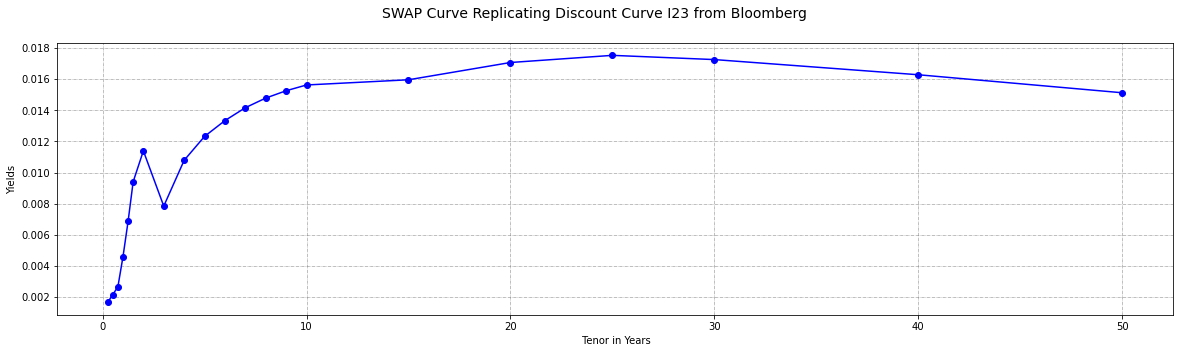

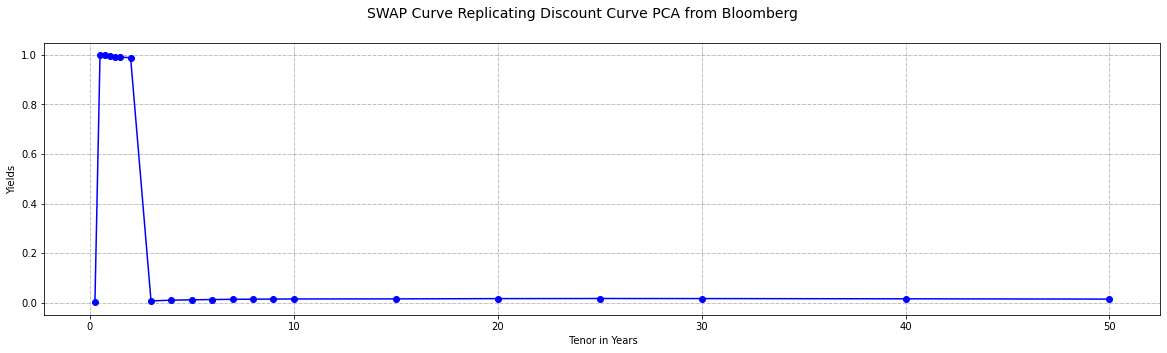

In [212]:
# curve tenors by Bloomberg classification
I23 = [0.25,0.5,0.75,1,1.25,1.5,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]
I203 = [3,4,5,6,7,8,9,10,15,20,25,30]
# 

curveplot1 = CurveConstruction(I23,DiscountCurveAdjusted,0,'Discount Curve I23')
curveplot1.Plot2DCurve()


curveplot2 = CurveConstruction(I23,rebuilt/100,0,'Discount Curve PCA')
curveplot2.Plot2DCurve()